In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from datetime import datetime

def log(message):
    print(datetime.now().strftime("%H:%M:%S -"), message)
    
def printnow():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)

In [ ]:
# Create the dictionary of dataframes for training and testing
section_headers = ['Intro','Verse','Refrain','Pre-Chorus','Chorus','Post-Chorus','Hooks','Riffs/Basslines','Scratches','Sampling','Bridge','Interlude','Skit','Collision','Instrumental','Solo','Ad-lib','Segue','Outro']
header_strip_list = '|'.join(['\[' + header + '\]' for header in section_headers])

def header_to_filename(train, header):
    if train: return 'section_train_test/train_' + header.replace('/', '_').lower() + '.zip'
    else: return 'section_train_test/test_' + header.replace('/', '_').lower() + '.zip'

log('Reading data from files')
train_dfs = {header:pd.read_pickle(header_to_filename(1, header)) for header in section_headers}
test_dfs = {header:pd.read_pickle(header_to_filename(0, header)) for header in section_headers}
log('Done\n')

# For dataframes without samples of each genre, add the empty string as lyrics for all genres
dummy_df = pd.DataFrame(data={'lyrics' : 8*[''], 'genre' : 2*['country', 'hiphop', 'pop', 'rock']})
for header in section_headers:
    if len(train_dfs[header]) < 5: train_dfs[header] = pd.concat([train_dfs[header], dummy_df])
    if len(test_dfs[header]) < 5: test_dfs[header] = pd.concat([test_dfs[header], dummy_df])
    train_dfs[header] = train_dfs[header].reset_index(drop=True)
    test_dfs[header] = test_dfs[header].reset_index(drop=True)


In [ ]:
log('Finding the counts of each section type in the corpus')
total_length = 0
for i,header in enumerate(section_headers):
    length = len(train_dfs[header]) + len(test_dfs[header])
    print(i + 1, header + ':', length)
    total_length += len(train_dfs[header]) + len(test_dfs[header])
log(f'Done: total length is {total_length}\n')

log('Finding the percent frequencies of each section type in the corpus')
corpus_weights = {}
for i,header in enumerate(section_headers):
    frequency = (len(train_dfs[header]) + len(test_dfs[header])) / total_length
    print(i + 1, header + ':', frequency)
    corpus_weights[header] = frequency
log('Done\n')


In [ ]:
# Load nonredundant data
country_df = pd.read_pickle(r'train_test_data/country_data.zip')
country_df['genre'] = 'country'
hiphop_df = pd.read_pickle(r'train_test_data/hiphop_data.zip')
hiphop_df['genre'] = 'hiphop'
pop_df = pd.read_pickle(r'train_test_data/pop_data.zip')
pop_df['genre'] = 'pop'
rock_df = pd.read_pickle(r'train_test_data/rock_data.zip')
rock_df['genre'] = 'rock'
full_df = pd.concat([country_df,hiphop_df, pop_df,rock_df])
full_df.reset_index(inplace=True, drop=True)
full_df

# Combine lyrics into one list to be input for tf-idf vectorizer WITH UNIGRAMS UP TO TRIGRAMS
full_lyrics = [lyrics.lower() for lyrics in full_df['lyrics']]
log(f'Training TF-IDF Vectorizer on all {len(full_lyrics)} lyrics')
tfidf_ngram_vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1,3)).fit(full_lyrics)
tfidf_ngram_features = tfidf_ngram_vectorizer.get_feature_names()
tfidf_ngram_data = tfidf_ngram_vectorizer.transform(full_lyrics)
log('Fitting SVD on all lyrics')
svd_ngram = TruncatedSVD(n_components=500).fit(tfidf_ngram_data)
log('Done\n')


In [ ]:
# Create TFIDF up to trigram encoding for nonredundant data
def encode_tfidf_ngram_svd(df): 
    tfidf_ngram_vec = tfidf_ngram_vectorizer.transform(df['lyrics'].values)
    svd_ngram_vec = svd_ngram.transform(tfidf_ngram_vec)
    tfidf_ngram_df = pd.DataFrame(svd_ngram_vec)
    tfidf_ngram_df['y'] = df['genre']
    return tfidf_ngram_df

# Create the training and testing encoded dataframes
log('Encoding the training data')
tfidf_train = {header:encode_tfidf_ngram_svd(train_dfs[header]) for header in section_headers}
log('Done\n')

log('Encoding the testing data')
tfidf_test = {header:encode_tfidf_ngram_svd(test_dfs[header]) for header in section_headers}
log('Done\n')


In [ ]:
# Load the string lyrics data to make predictions
log('Loading the raw string data')
string_train = pd.read_pickle(r'train_test_data/train.zip')
string_test = pd.read_pickle(r'train_test_data/test.zip')
log('Done\n')

# splits the given lyrics by section 
def split_by_section(lyrics):
    headers = [word[1:-1] for word in lyrics.split() if word[0] == '[' and word[-1] == ']' and word[1:-1] in section_headers]
    split_sections = re.split(header_strip_list, lyrics)
    ret_sections = []
    for section in split_sections:
        mod_section = section.replace('[END]','').replace('[START]','').strip()
        if not(mod_section in ['', ' ','\n']): ret_sections.append(mod_section)
    return list(zip(headers, ret_sections))

# Turn the raw string data into tuples of section strings and the lyrics of that section
log('Splitting the raw string data')
split_string_train = string_train
split_string_train['lyrics'] = string_train['lyrics'].map(split_by_section)
split_string_test = string_test
split_string_test['lyrics'] = string_test['lyrics'].map(split_by_section)
log('Done\n')


In [ ]:
# Encode the split string data with TFIDF (up to trigrams) and SVD 
def split_lyrics_encode(split_lyrics):
    sections_array = [section for section,lyrics in split_lyrics]
    lyrics_array = [lyrics + ' ' for section,lyrics in split_lyrics]
    try:
        tfidf_ngram_vec = tfidf_ngram_vectorizer.transform(lyrics_array)
        svd_ngram_vec = svd_ngram.transform(tfidf_ngram_vec)
        assert len(svd_ngram_vec) == len(sections_array)
        assert len(svd_ngram_vec[0]) == 500
        return list(zip(sections_array, svd_ngram_vec))
    except ValueError:
        log('ValueError' + str(len(sections_array)) + '\t' + str([len(lyrics) for lyrics in lyrics_array]))
        return list(zip(sections_array, np.array([[0]*500]*len(split_lyrics))))

# Turn the split string data into tuples of section strings and TFIDF encoded lyrics of that section
log('Splitting the encoding string lyrics of each section')
log('\tTesting set')
split_encoded_test = split_string_test
split_encoded_test['lyrics'] = split_string_test['lyrics'].map(split_lyrics_encode)
log('\tTraining set')
split_encoded_train = split_string_train
split_encoded_train['lyrics'] = split_string_train['lyrics'].map(split_lyrics_encode)
log('Done\n')


In [ ]:
log('Saving split encoded lyrics as pickles')
split_encoded_train.to_pickle('section_train_test/split_encoded_train.zip')
split_encoded_test.to_pickle('section_train_test/split_encoded_test.zip')
log('Done\n')


In [ ]:
log('Reading split encoded lyrics pickles into dataframes')
split_encoded_train = pd.read_pickle('section_train_test/split_encoded_train.zip')
split_encoded_test = pd.read_pickle('section_train_test/split_encoded_test.zip')
log('Done\n')


In [ ]:
class SectionSplitClassifier:
    def __init__(self, section_classifiers, weights):
        if section_classifiers:
            try: self.section_classifiers = {key:value for key,value in section_classifiers.items()}
            except AttributeError: raise ValueError('section_classifiers was not a dictionary')
        else: raise ValueError('section_classifiers was None')
        if weights:
            if np.round(np.sum([weight for weight in weights.values()])) == 1:
                try: self.weights = {key:value for key,value in weights.items()}
                except AttributeError: raise ValueError('weights was not a dictionary')
            else: raise ValueError('weights did not sum to 1')
        else: raise ValueError('weights was None')


    def set_section_classifiers(self, section_classifiers):
        if section_classifiers:
            try: self.section_classifiers = {key:value for key,value in section_classifiers.items()}
            except AttributeError: raise ValueError('section_classifiers was not a dictionary')
        else: raise ValueError('section_classifiers was None')


    def set_weights(self, weights):
        if weights:
            if np.round(np.sum([weight for weight in weights.values()])) == 1:
                try: self.weights = {key:value for key,value in weights.items()}
                except AttributeError: raise ValueError('weights was not a dictionary')
            else: raise ValueError('weights did not sum to 1')
        else: raise ValueError('weights was None')


    def fit(self, X, y, section, verbose=0, keras=0):
        if verbose: print(f'Training {section}...')
        if keras:
            history = self.section_classifiers[section].fit(X,y)
        else:
            self.section_classifiers[section] = self.section_classifiers[section].fit(X,y)
        if verbose: print(f'Done training {section}')


    def predict(self, X, keras=0):
        def predict_section(self, X_section, section, keras=0):
            def str_to_array(string, weight):
                return float(weight) * np.array([
                    int(string == 'country'), 
                    int(string == 'hiphop'),
                    int(string == 'pop'), 
                    int(string == 'rock')])
            if keras:
                return [str_to_array(pred, self.weights[section]) for pred in self.section_classifiers[section].predict([X_section])]
            else:
                return [str_to_array(pred, self.weights[section]) for pred in self.section_classifiers[section].predict(np.reshape(X_section, (-1,500)))]

        def predict_song(self, split_encoded, keras=0):
            def array_to_str(array):
                return ['country','hiphop','pop','rock'][np.argmax(array)]
            pred = np.array([0,0,0,0])
            for section,encoding in split_encoded:
                pred = np.sum([pred, predict_section(self, encoding, section, keras=keras)], axis=0)
            return array_to_str(pred)

        preds = [predict_song(self, lyrics) for lyrics in X]
        assert len(preds) == len(X)
        return(preds)



In [ ]:
# create the different kinds of section classifiers and their respective song classifiers
section_rf_classifiers = {
    header:RandomForestClassifier(criterion='entropy', ccp_alpha=0.0175) for header in section_headers}
section_rf_classifier = SectionSplitClassifier(section_rf_classifiers, corpus_weights)

section_ada_classifiers = {
    header:OneVsRestClassifier(AdaBoostClassifier(), n_jobs=-1) for header in section_headers}
section_ada_classifier = SectionSplitClassifier(section_ada_classifiers, corpus_weights)

section_svm_classifiers = {
    header:OneVsRestClassifier(SVC(kernel="linear", C=0.025), n_jobs=-1) for header in section_headers}
section_svm_classifier = SectionSplitClassifier(section_svm_classifiers, corpus_weights)

section_knn_classifiers = {
    header:OneVsOneClassifier(KNeighborsClassifier(3)) for header in section_headers}
section_knn_classifier = SectionSplitClassifier(section_knn_classifiers, corpus_weights)

# define baseline Keras neuralnet model
def baseline_model(input_dim):
	# create model
	model = Sequential()
	model.add(Dense(int(input_dim/2), input_dim=input_dim, activation='relu'))
	model.add(Dense(50, activation='relu'))
	model.add(Dense(4, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

section_net_classifiers = {
    header:KerasClassifier(build_fn=baseline_model, input_dim=500, epochs=20, batch_size=1, verbose=0) for header in section_headers}
section_net_classifier = SectionSplitClassifier(section_net_classifiers, corpus_weights)


Instructions for updating:
Colocations handled automatically by placer.


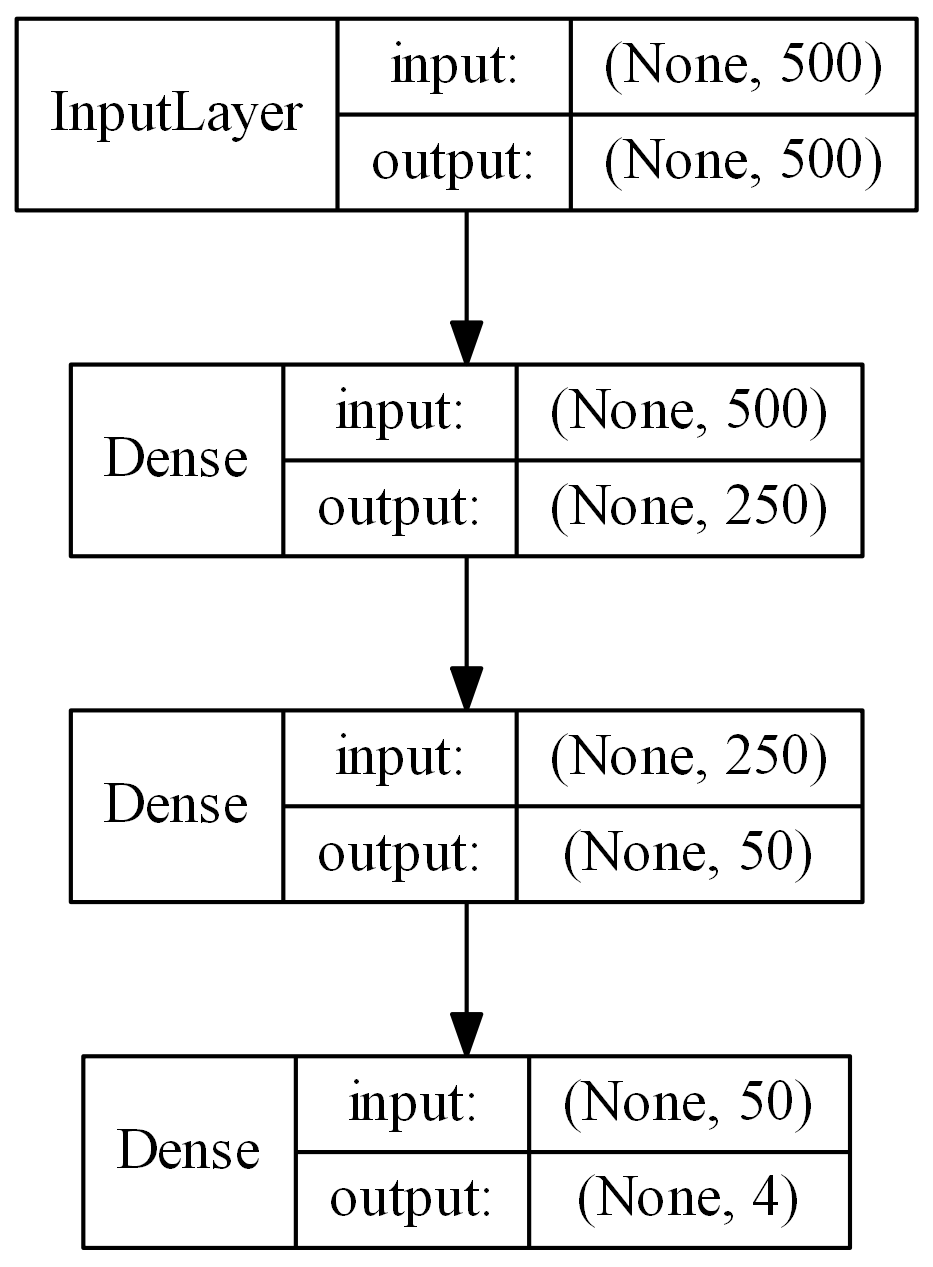

In [3]:
from keras.utils import plot_model
plot_model(baseline_model(500), to_file='tfidf_nn_image.png', show_shapes=True, show_layer_names=False, expand_nested=True, dpi=300)

In [ ]:
# train each kind of song classifier
# log('Training Random Forest classifier with all sections')
# for header in section_headers:
#     section_rf_classifier.fit(tfidf_train[header].drop(columns=['y']), tfidf_train[header]['y'], header, verbose=1)
# log('Done\n')

# log('Training ADA Boost classifier with all sections')
# for header in section_headers:
#     section_ada_classifier.fit(tfidf_train[header].drop(columns=['y']), tfidf_train[header]['y'], header, verbose=1)
# log('Done\n')

# log('Training Linear SVM classifier with all sections')
# for header in section_headers:
#     section_svm_classifier.fit(tfidf_train[header].drop(columns=['y']), tfidf_train[header]['y'], header, verbose=1)
# log('Done\n')

# log('Training k-Nearest Neighbors classifier with all sections')
# for header in section_headers:
#     section_knn_classifier.fit(tfidf_train[header].drop(columns=['y']), tfidf_train[header]['y'], header, verbose=1)
# log('Done\n')

log('Training Neural Net classifier with all sections')
for header in section_headers:
    section_net_classifier.fit(tfidf_train[header].drop(columns=['y']), tfidf_train[header]['y'], header, verbose=1, keras=1)
log('Done\n')


In [ ]:
def predict_write_results(filename, classifier_name, classifier, X_train, X_test, verbose=1):
    results_file = open(filename, 'a')
    if verbose: log(f'Predicting results for {classifier_name}')
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    if verbose: log('Done\n')

    if verbose:
        print(f'Training Set Accuracy: {accuracy_score(split_encoded_train["genre"], y_pred_train)}')
        print(f'Classification Report Training Set:\n{classification_report(split_encoded_train["genre"], y_pred_train)}')
        print(f'Confusion Matrix Training Set:\n{confusion_matrix(split_encoded_train["genre"], y_pred_train)}\n')
        print(f'Testing Set Accuracy: {accuracy_score(split_encoded_test["genre"], y_pred_test)}')
        print(f'Classification Report Testing Set:\n{classification_report(split_encoded_test["genre"], y_pred_test)}')
        print(f'Confusion Matrix Testing Set:\n{confusion_matrix(split_encoded_test["genre"], y_pred_test)}\n')

    results_file.write(f'Results for {classifier_name}\n')
    results_file.write(f'Training Set Accuracy: {accuracy_score(split_encoded_train["genre"], y_pred_train)}\n')
    results_file.write(f'Classification Report Training Set:\n{classification_report(split_encoded_train["genre"], y_pred_train)}')
    results_file.write(f'Confusion Matrix Training Set:\n{confusion_matrix(split_encoded_train["genre"], y_pred_train)}\n')
    results_file.write(f'Testing Set Accuracy: {accuracy_score(split_encoded_test["genre"], y_pred_test)}\n')
    results_file.write(f'Classification Report Testing Set:\n{classification_report(split_encoded_test["genre"], y_pred_test)}')
    results_file.write(f'Confusion Matrix Testing Set:\n{confusion_matrix(split_encoded_test["genre"], y_pred_test)}\n')
    results_file.write(str('-' * 30) + '\n')
    results_file.close()

    return y_pred_train, y_pred_test


In [ ]:
# predict the genres of both training and testing sets
log('start')
y_pred_train_rf, y_pred_test_rf = predict_write_results('eval_tfidf_section.txt', 'Random Forest Classifier', section_rf_classifier, split_encoded_train['lyrics'], split_encoded_test['lyrics'], verbose=1)
log('rf prediction done')

In [ ]:
log('start')
y_pred_train_ada, y_pred_test_ada = predict_write_results('eval_tfidf_section.txt', 'ADA Boost Classifier', section_ada_classifier, split_encoded_train['lyrics'], split_encoded_test['lyrics'], verbose=1)
log('ada prediction done')

In [ ]:
log('start')
y_pred_train_svm, y_pred_test_svm = predict_write_results('eval_tfidf_section.txt', 'Linear SVM Classifier', section_svm_classifier, split_encoded_train['lyrics'], split_encoded_test['lyrics'], verbose=1)
log('svm prediction done')

In [ ]:
log('start')
y_pred_train_knn, y_pred_test_knn = predict_write_results('eval_tfidf_section.txt', 'k-Nearest Neighbor Classifier', section_knn_classifier, split_encoded_train['lyrics'], split_encoded_test['lyrics'], verbose=1)
log('knn prediction done')

In [ ]:
split_encoded_train['lyrics']

In [ ]:
log('start')
y_pred_train_net, y_pred_test_net = predict_write_results('eval_tfidf_section.txt', 'Neural Net Classifier', section_net_classifier, split_encoded_train['lyrics'], split_encoded_test['lyrics'], verbose=1)
log('net prediction done')

In [ ]:
section_net_classifier.section_classifiers['Intro']

In [ ]:
# train each kind of song classifier on WHOLE CORPUS 
# to find an UPPER BOUND performance metric
tfidf_full = {header:pd.concat([tfidf_train[header], tfidf_test[header]]) for header in section_headers}

log('Training Random Forest classifier with all sections')
for header in section_headers:
    section_rf_classifier.fit(tfidf_full[header].drop(columns=['y']), tfidf_full[header]['y'], header, verbose=1)
log('Done\n')

log('Training ADA Boost classifier with all sections')
for header in section_headers:
    section_ada_classifier.fit(tfidf_full[header].drop(columns=['y']), tfidf_full[header]['y'], header, verbose=1)
log('Done\n')

log('Training Linear SVM classifier with all sections')
for header in section_headers:
    section_svm_classifier.fit(tfidf_full[header].drop(columns=['y']), tfidf_full[header]['y'], header, verbose=1)
log('Done\n')

log('Training k-Nearest Neighbors classifier with all sections')
for header in section_headers:
    section_knn_classifier.fit(tfidf_full[header].drop(columns=['y']), tfidf_full[header]['y'], header, verbose=1)
log('Done\n')


In [ ]:
results_file = open('eval_tfidf_section.txt', 'a')
results_file.write(str('-' * 30) + '\n')
results_file.write(str('-' * 30) + '\n')
results_file.write('\nTRAINING AND TESTING USING WHOLE CORPUS TO GET UPPERBOUND PERFORMANCE\nRESULTS BELOW\n\n')

In [ ]:
log('start')
y_pred_train_rf, y_pred_test_rf = predict_write_results('eval_tfidf_section.txt', 'Random Forest Classifier', section_rf_classifier, split_encoded_train['lyrics'], split_encoded_test['lyrics'], verbose=1)
log('rf prediction done')

In [ ]:
log('start')
y_pred_train_ada, y_pred_test_ada = predict_write_results('eval_tfidf_section.txt', 'ADA Boost Classifier', section_ada_classifier, split_encoded_train['lyrics'], split_encoded_test['lyrics'], verbose=1)
log('ada prediction done')

In [ ]:
log('start')
y_pred_train_svm, y_pred_test_svm = predict_write_results('eval_tfidf_section.txt', 'Linear SVM Classifier', section_svm_classifier, split_encoded_train['lyrics'], split_encoded_test['lyrics'], verbose=1)
log('svm prediction done')

In [ ]:
log('start')
y_pred_train_knn, y_pred_test_knn = predict_write_results('eval_tfidf_section.txt', 'k-Nearest Neighbor Classifier', section_knn_classifier, split_encoded_train['lyrics'], split_encoded_test['lyrics'], verbose=1)
log('knn prediction done')